In [ ]:
import pandas as pd
import numpy as np
from sklearn import preprocessing 
from fancyimpute import KNN   
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import cohen_kappa_score, make_scorer
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import files
files.upload()

Saving test.csv to test.csv
Saving train.csv to train.csv


{'test.csv': b'Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area\r\nLP001015,Male,Yes,0,Graduate,No,5720,0,110,360,1,Urban\r\nLP001022,Male,Yes,1,Graduate,No,3076,1500,126,360,1,Urban\r\nLP001031,Male,Yes,2,Graduate,No,5000,1800,208,360,1,Urban\r\nLP001035,Male,Yes,2,Graduate,No,2340,2546,100,360,,Urban\r\nLP001051,Male,No,0,Not Graduate,No,3276,0,78,360,1,Urban\r\nLP001054,Male,Yes,0,Not Graduate,Yes,2165,3422,152,360,1,Urban\r\nLP001055,Female,No,1,Not Graduate,No,2226,0,59,360,1,Semiurban\r\nLP001056,Male,Yes,2,Not Graduate,No,3881,0,147,360,0,Rural\r\nLP001059,Male,Yes,2,Graduate,,13633,0,280,240,1,Urban\r\nLP001067,Male,No,0,Not Graduate,No,2400,2400,123,360,1,Semiurban\r\nLP001078,Male,No,0,Not Graduate,No,3091,0,90,360,1,Urban\r\nLP001082,Male,Yes,1,Graduate,,2185,1516,162,360,1,Semiurban\r\nLP001083,Male,No,3+,Graduate,No,4166,0,40,180,,Urban\r\nLP001094,Male,Yes,2,Graduate,,12173

In [ ]:
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")

In [ ]:
train.head(2)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N


In [ ]:
#Loan ID is dropped because it is not required
train=train.drop(["Loan_ID"],axis=1)
test=test.drop(["Loan_ID"],axis=1)

In [ ]:
print(train.isnull().sum())

Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             601 non-null    object 
 1   Married            611 non-null    object 
 2   Dependents         599 non-null    object 
 3   Education          614 non-null    object 
 4   Self_Employed      582 non-null    object 
 5   ApplicantIncome    614 non-null    int64  
 6   CoapplicantIncome  614 non-null    float64
 7   LoanAmount         592 non-null    float64
 8   Loan_Amount_Term   600 non-null    float64
 9   Credit_History     564 non-null    float64
 10  Property_Area      614 non-null    object 
 11  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(7)
memory usage: 57.7+ KB


In [ ]:
#Credit History and Loan Amount Term are categorical variables
train["Credit_History"]=train["Credit_History"].astype("object")

In [ ]:
#KNN imputation
#Assigning levels to the categories
lis = []
for i in range(0, train.shape[1]):
    if(train.iloc[:,i].dtypes == 'object'):
        train.iloc[:,i] = pd.Categorical(train.iloc[:,i])
        train.iloc[:,i] = train.iloc[:,i].cat.codes 
        train.iloc[:,i] = train.iloc[:,i].astype('object')
        lis.append(train.columns[i])

In [ ]:
#replace -1 with NA to impute
for i in range(0, train.shape[1]):
    train.iloc[:,i] = train.iloc[:,i].replace(-1, np.nan) 

In [ ]:
#Apply KNN imputation algorithm
train = pd.DataFrame(KNN(k = 3).fit_transform(train), columns = train.columns)

Imputing row 1/614 with 1 missing, elapsed time: 0.073
Imputing row 101/614 with 0 missing, elapsed time: 0.074
Imputing row 201/614 with 0 missing, elapsed time: 0.075
Imputing row 301/614 with 0 missing, elapsed time: 0.076
Imputing row 401/614 with 0 missing, elapsed time: 0.077
Imputing row 501/614 with 0 missing, elapsed time: 0.078
Imputing row 601/614 with 2 missing, elapsed time: 0.079


In [ ]:
#Convert into proper datatypes
for i in lis:
    train.loc[:,i] = train.loc[:,i].round()
    train.loc[:,i] = train.loc[:,i].astype('object')

In [ ]:
train.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,1,0,0,0,0,5849.0,0.0,139.237669,360.0,1,2,1
1,1,1,1,0,0,4583.0,1508.0,128.000000,360.0,1,0,0
2,1,1,0,0,1,3000.0,0.0,66.000000,360.0,1,2,1
3,1,1,0,1,0,2583.0,2358.0,120.000000,360.0,1,2,1
4,1,0,0,0,0,6000.0,0.0,141.000000,360.0,1,2,1


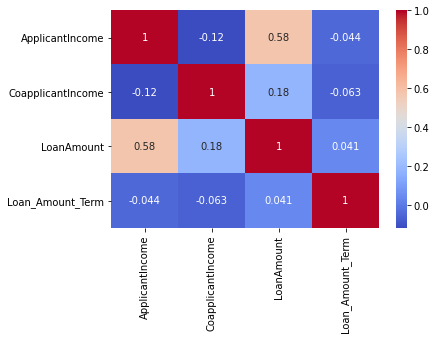

In [ ]:
#Checking correlation between continuous variable
numvar=["ApplicantIncome","CoapplicantIncome","LoanAmount","Loan_Amount_Term"]
df_corr = train.loc[:,numvar]
sns.heatmap(df_corr.corr(), annot = True, fmt='.2g',cmap= 'coolwarm')

In [ ]:
#Standardizing the numerical variables
train["ApplicantIncome"]= (train["ApplicantIncome"] - train["ApplicantIncome"].mean())/train["ApplicantIncome"].std()
train["CoapplicantIncome"]= (train["CoapplicantIncome"] - train["CoapplicantIncome"].mean())/train["CoapplicantIncome"].std()
train["LoanAmount"]= (train["LoanAmount"] - train["LoanAmount"].mean())/train["LoanAmount"].std()
train["Loan_Amount_Term"]= (train["Loan_Amount_Term"] - train["Loan_Amount_Term"].mean())/train["Loan_Amount_Term"].std()

In [ ]:
X=train.drop(["Loan_Status"],axis=1)
Y=train["Loan_Status"]
Y=Y.astype(int)
x=np.array(X)
y=np.array(Y)

In [ ]:
#GBM and XGBoost
gbm = GradientBoostingClassifier()
xgb = XGBClassifier()

In [ ]:
best_gbm = GridSearchCV(gbm, param_grid={'learning_rate':[0.01,0.05,0.1],'max_depth':[3,4,5],'n_estimators':[500]}, cv=5,scoring="accuracy", n_jobs=-1)
best_xgb = GridSearchCV(xgb, param_grid={'learning_rate':[0.01,0.05,0.1],'max_depth':[3,4,5],'n_estimators':[500]}, cv=5,scoring="accuracy", n_jobs=-1)
best_gbm.fit(x,y)
best_xgb.fit(x,y)
scores = cross_val_score(best_gbm.best_estimator_, x, y,scoring="accuracy", cv=5)
print("GBM Cross validation accuracy score: {0:.2%} (+/- {1:.2%})".format(np.mean(scores), np.std(scores)*2))
scores = cross_val_score(best_xgb.best_estimator_, x, y,scoring="accuracy", cv=5)
print("XGBoost Cross validation accuracy score: {0:.2%} (+/- {1:.2%})".format(np.mean(scores), np.std(scores)*2))

GBM Cross validation accuracy score: 79.65% (+/- 5.86%)
XGBoost Cross validation accuracy score: 79.97% (+/- 4.63%)


In [ ]:
best_gbm1 = GridSearchCV(gbm, param_grid={'learning_rate':[0.01,0.05,0.1],'max_depth':[3,4,5],'n_estimators':[500]}, cv=5,scoring="recall", n_jobs=-1)
best_xgb1 = GridSearchCV(xgb, param_grid={'learning_rate':[0.01,0.05,0.1],'max_depth':[3,4,5],'n_estimators':[500]}, cv=5,scoring="recall", n_jobs=-1)
best_gbm1.fit(x,y)
best_xgb1.fit(x,y)
scores = cross_val_score(best_gbm1.best_estimator_, x, y,scoring="recall", cv=5)
print("GBM Cross validation recall score: {0:.2%} (+/- {1:.2%})".format(np.mean(scores), np.std(scores)*2))
scores = cross_val_score(best_xgb1.best_estimator_, x, y,scoring="recall", cv=5)
print("XGBoost Cross validation recall score: {0:.2%} (+/- {1:.2%})".format(np.mean(scores), np.std(scores)*2))

GBM Cross validation recall score: 95.26% (+/- 3.36%)
XGBoost Cross validation recall score: 96.20% (+/- 1.80%)


In [ ]:
#Naive Bayes
parameters = {'priors':[[0.01, 0.99],[0.1, 0.9], [0.2, 0.8], [0.25, 0.75], [0.3, 0.7],[0.35, 0.65], [0.4, 0.6],[0.45,0.55],[0.5,0.5],[0.55,0.45],[0.6,0.4]]}
nb = GridSearchCV(GaussianNB(), parameters, scoring = 'accuracy', n_jobs=-1)
nb.fit(x, y)
scores = cross_val_score(nb, x, y,scoring = 'accuracy', cv=5)
print("Cross validation accuracy score: {0:.2%} (+/- {1:.2%})".format(np.mean(scores), np.std(scores)*2))

Cross validation accuracy score: 79.97% (+/- 5.83%)


In [ ]:
nb1 = GridSearchCV(GaussianNB(), parameters, scoring = 'recall', n_jobs=-1)
nb1.fit(x, y)
scores = cross_val_score(nb1, x, y,scoring = 'recall', cv=5)
print("Cross validation recall score: {0:.2%} (+/- {1:.2%})".format(np.mean(scores), np.std(scores)*2))

Cross validation recall score: 95.97% (+/- 3.85%)


In [ ]:
#Random Forest
parameters = {'n_estimators':[500], 'criterion':['gini', 'entropy']}
rf = GridSearchCV(RandomForestClassifier(random_state=42), parameters, scoring = 'accuracy', n_jobs=-1)
rf.fit(x, y)
scores = cross_val_score(rf, x, y,scoring="accuracy", cv=5)
print("Cross validation accuracy score: {0:.2%} (+/- {1:.2%})".format(np.mean(scores), np.std(scores)*2))

Cross validation accuracy score: 79.32% (+/- 5.26%)


In [ ]:
rf1 = GridSearchCV(RandomForestClassifier(random_state=42), parameters, scoring = 'recall', n_jobs=-1)
rf1.fit(x, y)
scores = cross_val_score(rf1, x, y,scoring="recall", cv=5)
print("Cross validation recall score: {0:.2%} (+/- {1:.2%})".format(np.mean(scores), np.std(scores)*2))

Cross validation recall score: 93.60% (+/- 1.93%)


Doing all the similar pre processing for test data

In [ ]:
test["Credit_History"]=test["Credit_History"].astype("object")

In [ ]:
#KNN imputation
#Assigning levels to the categories
lis = []
for i in range(0, test.shape[1]):
    if(test.iloc[:,i].dtypes == 'object'):
        test.iloc[:,i] = pd.Categorical(test.iloc[:,i])
        test.iloc[:,i] = test.iloc[:,i].cat.codes 
        test.iloc[:,i] = test.iloc[:,i].astype('object')
        lis.append(test.columns[i])

In [ ]:
#replace -1 with NA to impute
for i in range(0, test.shape[1]):
    test.iloc[:,i] = test.iloc[:,i].replace(-1, np.nan) 

In [ ]:
#Apply KNN imputation algorithm
test = pd.DataFrame(KNN(k = 3).fit_transform(test), columns = test.columns)

Imputing row 1/367 with 0 missing, elapsed time: 0.033
Imputing row 101/367 with 0 missing, elapsed time: 0.034
Imputing row 201/367 with 0 missing, elapsed time: 0.036
Imputing row 301/367 with 0 missing, elapsed time: 0.037


In [ ]:
#Convert into proper datatypes
for i in lis:
    test.loc[:,i] = test.loc[:,i].round()
    test.loc[:,i] = test.loc[:,i].astype('object')

In [ ]:
test["ApplicantIncome"]= (test["ApplicantIncome"] - test["ApplicantIncome"].mean())/test["ApplicantIncome"].std()
test["CoapplicantIncome"]= (test["CoapplicantIncome"] - test["CoapplicantIncome"].mean())/test["CoapplicantIncome"].std()
test["LoanAmount"]= (test["LoanAmount"] - test["LoanAmount"].mean())/test["LoanAmount"].std()
test["Loan_Amount_Term"]= (test["Loan_Amount_Term"] - test["Loan_Amount_Term"].mean())/test["Loan_Amount_Term"].std()

In [ ]:
x=np.array(test)

In [ ]:
#Prediction
ypred=best_xgb1.best_estimator_.predict(x)

1: Y
0: N

In [ ]:
test=pd.read_csv("test.csv")
test["Loan_Status"]=ypred

In [ ]:
dict = {0 : 'N', 1: 'Y'} 

In [ ]:
test['Loan_Status']= test['Loan_Status'].map(dict) 

In [ ]:
test.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

In [ ]:
test=test.drop(['Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area'],axis=1)

In [ ]:
test.head()

,Loan_ID,Loan_Status
0,LP001015,Y
1,LP001022,Y
2,LP001031,Y
3,LP001035,Y
4,LP001051,N


In [ ]:
test.to_csv("submissionfinal.csv")